In [48]:
import torch
import numpy as np
import imutils
import time
import cv2

from PIL import Image, ImageOps, ImageFont, ImageDraw
from torchvision import transforms

import matplotlib.pyplot as plt
import torch.nn as nn

import models.MathNet as mnt
import models.MathNet112 as mnt112
from utils.letter import Letter
from utils.printer import PrettyPrinter

In [2]:
MODEL_PATH = 'models\mathnet224\mathnet.ml'
printer = PrettyPrinter()

In [3]:
#CUDA_LAUNCH_BLOCKING=1
torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
kwargs = dict(
    PYR_SCALE=1.25,
    WIN_STEP=3,
    ROI_SIZE=(21, 21),
    INPUT_SIZE=(28, 28),
    VISUALIZE=True,
    MIN_CONF=0.4
)

In [122]:
IMAGE_NAME = 'TEST/5.jpg'
image = cv2.imread(IMAGE_NAME)

img_grey = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

#set a thresh
thresh = 120

#get threshold image
ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)

#find contours
contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img_contours = np.uint8(np.zeros((image.shape[0],image.shape[1])))



In [123]:
cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
1

1

In [9]:
def resize_letter(image, dst):
    return None

In [157]:
def average_size(lst):
    if len(lst) <= 0:
        return (0, 0)
    avg_w = 0
    avg_h = 0
    for letter in lst:
        avg_w += letter.width
        avg_h += letter.height
    avg_w /= len(lst)
    avg_h /= len(lst)
    
    return (avg_w, avg_h)

In [124]:
def add_contrast(x, factor):
    return transforms.functional.adjust_contrast(x, factor)

In [189]:
class ContoursDetector():
    def __init__(self, model, kwargs):
        self.model = model
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(device)
        self.model.eval()
        self.kwargs = kwargs

    
    def preprocess(self, image):
        output = image.copy()
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.blur(gray, (3, 3))
        thresh = 100
        thresh_img = cv2.adaptiveThreshold(blurred, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,5,8)
        #ret,thresh_img = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)
        
        img_erode = cv2.erode(thresh_img, np.ones((3, 3), np.uint8), iterations=1)
        
        img_erode = self.__add_border(img_erode)
        if self.kwargs['DEBUG'] == True:
            cv2.imshow('preprocess', img_erode)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
        return img_erode

    def __add_border(self, image):
        pad = 10
        mask1 = np.uint8(np.ones((int(image.shape[0] - 2 * pad), int(image.shape[1] - 2 * pad))) * 255.0)
        mask2 = np.pad(mask1, pad_width=pad)
        print(image.shape, mask1.shape, mask2.shape)
        res = cv2.bitwise_and(mask2, image)
        res = cv2.bitwise_or(cv2.bitwise_not(mask2), res)
        return res

    def get_rois(self, image):
         # Get contours
        contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)       
        img_contours = np.uint8(np.zeros((image.shape[0],image.shape[1])))
        # Filter contours
        mask = np.uint8(np.zeros((image.shape[0],image.shape[1])))
        for idx, contour in enumerate(contours):
            (x, y, w, h) = cv2.boundingRect(contour)
            if cv2.contourArea(contour) > 10 and cv2.contourArea(contour) < 10000:
                cv2.drawContours(mask, [contour], 0, (255), -1)
            else:
                pass
    #             dummy = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    #             cv2.drawContours(dummy, contour, -1, (255,255,255), 1)
    #             print(w*h, cv2.contourArea(contour))
    #             cv2.imshow(str(idx), dummy )
    #             cv2.waitKey(0)
    #             cv2.destroyAllWindows()
                
    #     # apply the mask to the original image
        result = cv2.bitwise_and(image,image, mask= mask)
        
        contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        img_contours = np.uint8(np.zeros((image.shape[0],image.shape[1])))
        cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
        
        letters = []
        for idx, contour in enumerate(contours):
            (x, y, w, h) = cv2.boundingRect(contour)
            #print("R", idx, x, y, w, h, cv2.contourArea(contour), hierarchy[0][idx])
            if hierarchy[0][idx][3] != -1:
                continue
            crop_img = image[y:y+h, x:x+w]
            #crop_img = thresh_img[y:y+h, x:x+w]
            size_max = max(w, h)
            letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
            if w > h:
                y_pos = size_max//2 - h//2
                letter_square[y_pos:y_pos + h, 0:w] = crop_img
            elif w < h:
                x_pos = size_max//2 - w//2
                letter_square[0:h, x_pos:x_pos + w] = crop_img
            else:
                letter_square = crop_img
            #letter_square = cv2.dilate(letter_square, np.ones((3, 3), np.uint8), iterations=1)
            x,y,w,h = cv2.boundingRect(contour)
            #rect = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255,0), 2)      
            inverted = cv2.bitwise_not(letter_square)
            
            letter = Letter(x,y,w,h,letter_square)
            letters.append(letter)
        return letters

    def visualize_rois(self, img, rois):
        output = Image.fromarray(img.astype('uint8'))        
        res_letters = []
        for idx in range(0, len(rois)):
            roi = rois[idx]
            res_letters.append(roi)
            draw = ImageDraw.Draw(output)
            draw.rectangle((roi.x, roi.y, roi.right, roi.bottom), outline=(255,0,0))
        output.show()
        return (output, res_letters)
        
    def visualize_preds(self, img, letters):
        #output = Image.new("RGBA", img.size)
        output = Image.fromarray(img.astype('uint8'))
        output = output.convert('RGB')
        font = ImageFont.truetype("T:\my_programs\Math_recognition\ARIALUNI.TTF", 10, encoding="unic")
        draw = ImageDraw.Draw(output)
        res_letters = []
        for letter in letters:
            res_letters.append(letter)
            draw.rectangle((letter.x, letter.y, letter.x+letter.width, letter.y+letter.height), outline=(0,255,0))
            draw.text((letter.x, letter.y), "{}; {:.3f}.".format(mnt.map_pred(letter.value), letter.score), font=font, fill=(200,40,0,255))
        if self.kwargs['DEBUG'] == True:
            #output.show()
            display(output)
        return (output, res_letters)

    def get_exact_locations(self, rois):
        res = []
        (avg_w, avg_h) = average_size(rois)
        for letter in rois:
            if letter.w < avg_w / 2 and letter.height - avg_h / 2 < 0:
                continue
            res.append(letter)
        return res
    
    def predict(self, letters):
        regions_of_interest = []
        labels = {}
        torch.cuda.empty_cache()
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        for letter in letters:
            img = Image.fromarray(letter.image.astype('uint8'))
            #print(img.size)
            convert_tensor = transforms.Compose([
                transforms.Resize(self.kwargs['INPUT_SIZE']),
                transforms.Grayscale(1),
                # transforms.ToTensor()

            ])
            x_image = convert_tensor(img)
            x_image = add_contrast(x_image, 5)
            to_tensor = transforms.ToTensor()

            x_image = to_tensor(x_image)
            
            x_image = x_image.unsqueeze(0).float()
            x_image = x_image.to(device)

            predicted = self.model(x_image)
            prob = predicted.max().item()
            if prob >= self.kwargs['MIN_CONF']:
                letter.value = predicted.argmax().item()
                letter.score = prob

                ll = labels.get(letter.value, [])
                ll.append(letter)
                labels[letter.value] = ll
                regions_of_interest.append(letter)
                #display(img)
        return (regions_of_interest, labels)
    

    def __call__(self, img):
        processed_image = self.preprocess(img)
        regions_of_interest = self.get_rois(processed_image)

        if self.kwargs['DEBUG'] == True:
            print('regions_of_interest = ', len(regions_of_interest))
            self.visualize_rois(img, regions_of_interest)

        regions_of_interest = self.get_exact_locations(regions_of_interest)
        #self.add_spaces_to_letter(regions_of_interest)

        (regions_of_interest, preds) = self.predict(regions_of_interest)
        if self.kwargs['DEBUG'] == True:
            print('letters predicted = ', len(regions_of_interest))

        if self.kwargs['DEBUG'] == True:
            print('found letters = ', len(regions_of_interest))
        (_, letters) = self.visualize_preds(processed_image, regions_of_interest)
        # printer = PrettyPrinter()
        # printer.print(letters)
        return (_, letters)

(960, 1280) (940, 1260) (960, 1280)
regions_of_interest =  25
letters predicted =  22
found letters =  22


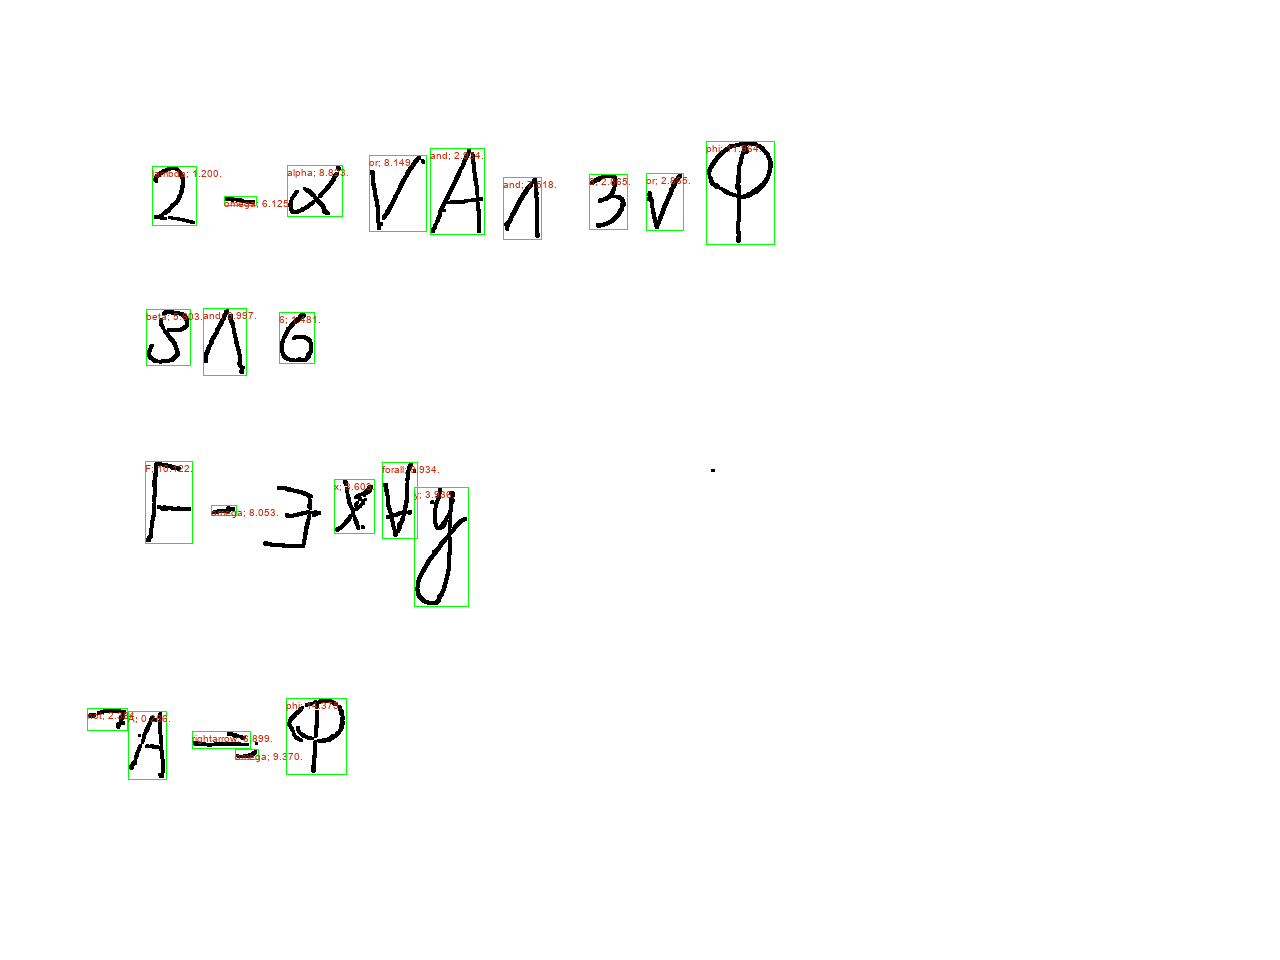

In [190]:
path = 'T:\my_programs\Math_recognition\TEST\\real5.jpg'
kwargs = dict(
        INPUT_SIZE=(224, 224),
        VISUALIZE=True,
        MIN_CONF=0.05,
        DEBUG=True
    )
image = cv2.imread(path)
cv2.imshow('yy',image)
cv2.waitKey(0)
model = mnt.MathNet()
model.load_state_dict(torch.load(MODEL_PATH))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
sw = ContoursDetector(model, kwargs)
res = sw(image)


15


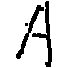

In [204]:
first = res[1][2]
let_image = Image.fromarray(first.image.astype('uint8'))
print(first.value)
display(let_image)

In [142]:
def letters_extract(image_file, debug=False):
    img = cv2.imread(image_file)
    output = img.copy()
    if debug==True:
        cv2.imshow('MyPhoto', img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    thresh = 100
    thresh_img = cv2.adaptiveThreshold(gray, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,5,8)
    ret,thresh_img = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)
    if debug==True:
        cv2.imshow('thresh_img', thresh_img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    img_erode = cv2.erode(thresh_img, np.ones((3, 3), np.uint8), iterations=1)
    if debug==True:
        cv2.imshow('MyPhoto', img_erode)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    

    # Get contours
    contours, hierarchy = cv2.findContours(img_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)       
    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    # cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
    # cv2.imshow('img_contours', img_contours )
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
       
    # Filter contours
    mask = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        if cv2.contourArea(contour) > 10 and cv2.contourArea(contour) < 10000:
            cv2.drawContours(mask, [contour], 0, (255), -1)
        else:
            pass
#             dummy = np.uint8(np.zeros((img.shape[0],img.shape[1])))
#             cv2.drawContours(dummy, contour, -1, (255,255,255), 1)
#             print(w*h, cv2.contourArea(contour))
#             cv2.imshow(str(idx), dummy )
#             cv2.waitKey(0)
#             cv2.destroyAllWindows()
            
#     # apply the mask to the original image
    result = cv2.bitwise_and(img,img, mask= mask)   
    if debug==True:
        cv2.imshow('result', result )
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    img_contours = np.uint8(np.zeros((img.shape[0],img.shape[1])))
    cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
    if debug==True:
        cv2.imshow('Contours', img_contours )
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
    letters = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        #print("R", idx, x, y, w, h, cv2.contourArea(contour), hierarchy[0][idx])
        if hierarchy[0][idx][3] != -1:
            continue
#         mask_contour = img_contours[y:y+h, x:x+w]
#         mask_contour[y_pos:y_pos + h, 0:w] = crop_img
#         cv2.drawContours(mask_contour, contour, -1, (255,255,255), 1)
#         cv2.imshow('MyPhoto', mask_contour)
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()

#         cv2.imwrite('mask.png', img * max(img - 100, 0) * 255)
#         ii = cv2.imread('mask.png')
#         cv2.imshow('MyPhoto', ii )
#         cv2.waitKey(0)
#         cv2.destroyAllWindows()
        crop_img = img_erode[y:y+h, x:x+w]
        #crop_img = thresh_img[y:y+h, x:x+w]
        size_max = max(w, h)
        letter_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
        if w > h:
            y_pos = size_max//2 - h//2
            letter_square[y_pos:y_pos + h, 0:w] = crop_img
        elif w < h:
            x_pos = size_max//2 - w//2
            letter_square[0:h, x_pos:x_pos + w] = crop_img
        else:
            letter_square = crop_img
        #letter_square = cv2.dilate(letter_square, np.ones((3, 3), np.uint8), iterations=1)
        x,y,w,h = cv2.boundingRect(contour)
        #rect = cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255,0), 2)      
        inverted = cv2.bitwise_not(letter_square)
        
        letter = Letter(x,y,w,h,letter_square)
        letters.append(letter)

    letters.sort(key=lambda ll: (ll.y, ll.x), reverse=False)
    aaa = Image.fromarray(output.astype('uint8'))
    #display(aaa)
    return (letters, aaa)

NameError: name 'ContoursDetector' is not defined

In [55]:
def average_size(lst):
    if len(lst) <= 0:
        return (0, 0)
    avg_w = 0
    avg_h = 0
    for letter in lst:
        avg_w += letter.width
        avg_h += letter.height
    avg_w /= len(lst)
    avg_h /= len(lst)
    
    return (avg_w, avg_h)

In [143]:



def img_to_str(model, image_file, debug=False):
    (letters, output) = letters_extract(image_file)   
    font = ImageFont.truetype("T:\my_programs\Math_recognition\ARIALUNI.TTF", 10, encoding="unic")
    draw = ImageDraw.Draw(output)
    
    print('SHAPE: ', np.array(letters,dtype=object).shape)
    if len(letters) == 0:
        return "Found nothing"
    (avg_w, avg_h) = average_size(letters)
    print((avg_w, avg_h))
    
    # True sorting by Y axis
    line = 0
    for i in range (1, len(letters)):
        if letters[i].top > letters[i-1].bottom:
            line += 1
        letters[i].line = line
    letters.sort(key=lambda ll: (ll.line, ll.x), reverse=False)  
    
    prev_loc = (letters[0].x, letters[0].y)
    prev_size = (letters[0].width, letters[0].height)
    prev_line = letters[0].line
    #for i in range(1):
    for letter in letters:
        
        img = Image.fromarray(letter.image.astype('uint8'))
        convert_tensor = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.Grayscale(1),
            # transforms.ToTensor()

        ])         
        x_image = convert_tensor(img)
        x_image = add_contrast(x_image, 5)
        to_tensor = transforms.ToTensor()

        x_image = to_tensor(x_image)
        aaa = transforms.ToPILImage()
        #display(aaa(x_image))
        x_image = x_image.unsqueeze(0).float()
        x_image = x_image.to(device)
        pred = model(x_image) 
        letter.score = pred.max().item()
        #print(letter.score)
        if letter.score > 0.65:
            letter.value = pred.argmax().item()
            x = letter.x
            y = letter.y
            size = (letter.width, letter.height)
            if (letter.line >  prev_line):
                prev_line = letter.line
            prev_loc, prev_size = (x,y), size
            #print(letter.image.shape, letter.value, prob)
            draw.rectangle((letter.x, letter.y, letter.x+letter.width, letter.y+letter.height), outline=(0,255,0))
            draw.text((letter.x, letter.y), "{}; {:.3f}.".format(mnt.map_pred(letter.value), letter.score), font=font, fill=(200,40,0,255))
    display(output)
    #output.show()

In [144]:
model = mnt.MathNet()
model.load_state_dict(torch.load(MODEL_PATH))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
print('EVALUATION')

EVALUATION


SHAPE:  (29,)
(37.48275862068966, 47.793103448275865)


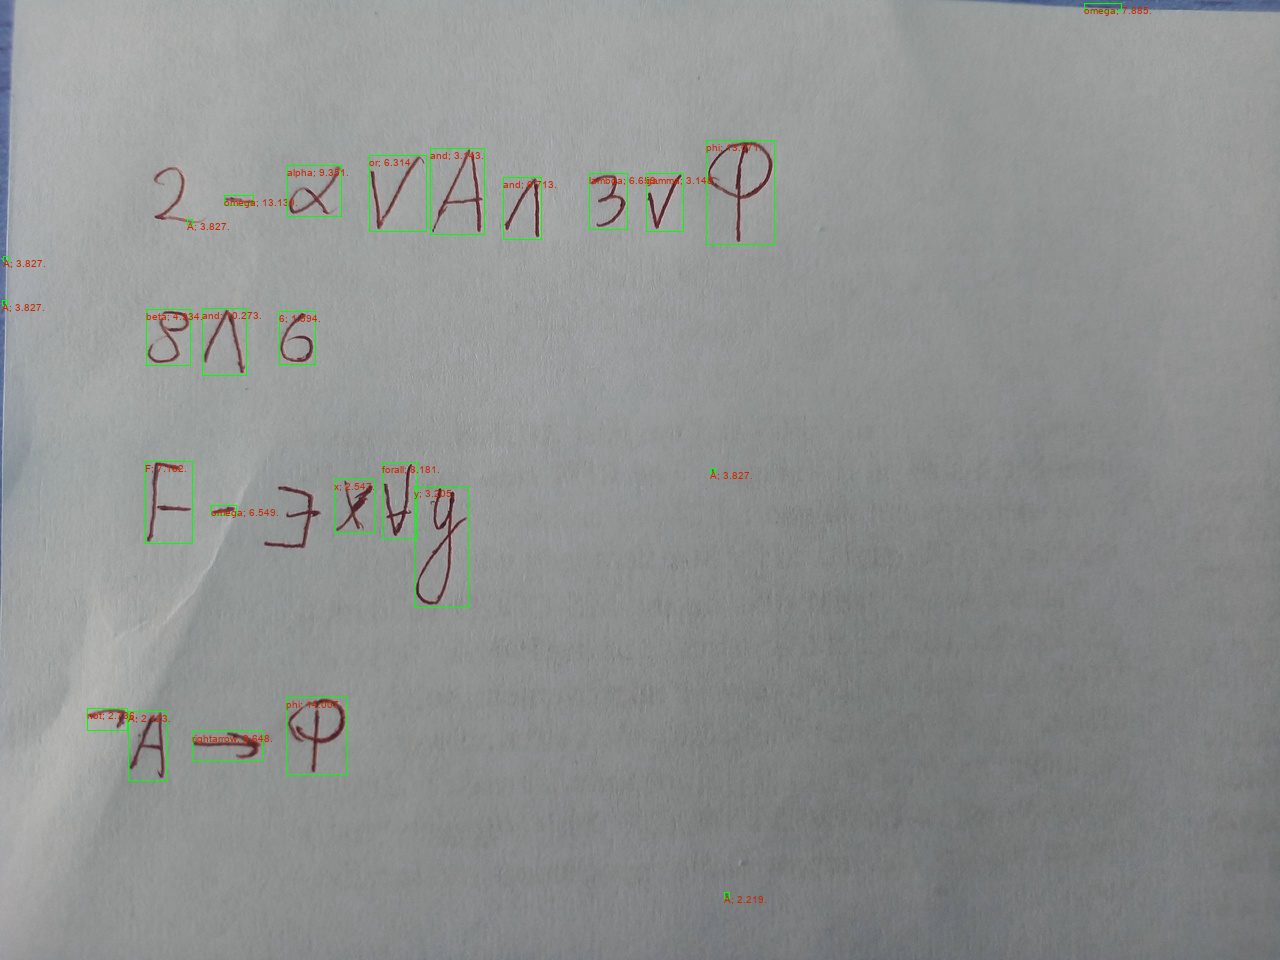

RESULT:
None


In [145]:
s = img_to_str(model, 'TEST/real5.jpg', 1)
print('RESULT:')
print(s)

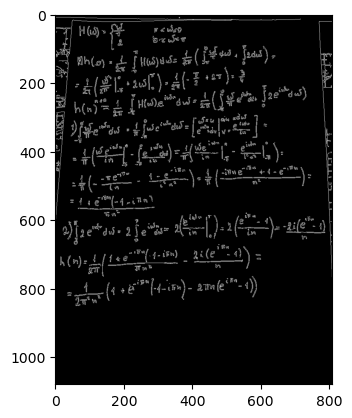

-1

In [16]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('TEST/h.jpg')
edges = cv2.Canny(img,25,255,L2gradient=False)
cv2.imshow('Start image', img)
plt.imshow(edges, cmap='gray')
plt.show()
cv2.waitKey(0)

In [17]:
# import os
# from os import makedirs
# from os.path import isfile, join, exists

# def custom_sort(countour):
#     return -cv2.contourArea(countour)

# def remove_isolated_pixels(image):
#     connectivity = 8

#     output = cv2.connectedComponentsWithStats(image, connectivity, cv2.CV_32S)

#     num_stats = output[0]
#     labels = output[1]
#     stats = output[2]

#     new_image = image.copy()

#     for label in range(num_stats):
#         if stats[label,cv2.CC_STAT_AREA] == 1:
#             new_image[labels == label] = 0

#     return new_image

# symbol = 'sigma'
# path = r'E:\Download\Query\\' + symbol + '\\'
# onlyfiles = [f for f in os.listdir(path) if os.path.isfile(join(path, f))]
# if not os.path.exists(path + 'new\\'):
#     makedirs(path + 'new\\')
# for i, file in enumerate(onlyfiles):
#     img = cv2.imread(path + '\\' + file)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     # Get contours
    
#     for x in range(0, img.shape[1]):
#         gray[img.shape[0]-6][x] = 255
#     for x in range(0, 3):    
#         for y in range(0, img.shape[0]):
#             gray[y][x] = 255
#             gray[y][ img.shape[1] - 1 - x] = 255

#     gray = cv2.bitwise_not(gray)
#     gray =  cv2.bitwise_not(remove_isolated_pixels(gray))
#     #gray = cv2.erode(gray, np.ones((3, 3), np.uint8), iterations=1)
#     cv2.imwrite(path + 'new\\' + symbol + '-' + str(i) + '.jpg', gray)

#     # cv2.imshow('result', img )
#     # cv2.waitKey(0)
#     # cv2.destroyAllWindows()

In [18]:
# import os
# from os import makedirs
# from os.path import isfile, join, exists

# symbol = '_h'
# #path = r'G:\TRAIN\extracted_images\\' + symbol + '\\'
# #path = r'G:\TRAIN\hasy_sorted\\' + symbol + '\\'
# #path = r'G:\TRAIN\by_class\\' + symbol + '\\'
# #path = r'E:\Download\Query\\' + symbol + '\\'
# path = r'E:\TRAIN\emnist\\' + symbol + '\\'
# onlyfiles = [f for f in os.listdir(path) if isfile(join(path, f))]
# if not os.path.exists(path + 'sized\\'):
#     makedirs(path + 'sized\\')

# for i, file in enumerate(onlyfiles):
#     img = cv2.imread(path + '\\' + file)
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     gray = cv2.resize(gray, (224, 224), interpolation = cv2.INTER_AREA)

#     #cv2.imwrite(path + 'sized\\' + symbol + '-' + str(i) + '.jpg', gray)
#     gray = cv2.flip(gray, 0)
#     #gray = cv2.rotate(gray, cv2.ROTATE_90_CLOCKWISE)
#     cv2.imwrite(path + 'sized\\' + symbol + '-' + str(i) + '-mirror.jpg', gray)
    
#     # gray = cv2.erode(gray, np.ones((3, 3), np.uint8), iterations=1)
#     # cv2.imwrite(path + 'sized\\' + symbol + '-' + str(i) + 'erode.jpg', gray)  
#     # cv2.imshow('result', img )
#     # cv2.waitKey(0)
#     # cv2.destroyAllWindows()

50176
48479
0.966179049744898
Center of mass coordinates: (99.35474366529169, 101.2692987625221)
10 (204, 204) (224, 224)
ok


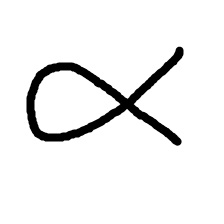

In [2]:
img = Image.open("TEST/0.jpg")
roiOrig = cv2.imread("TEST/0.jpg")
roiOrig = cv2.cvtColor(roiOrig,cv2.COLOR_BGR2GRAY)

def add_border(image):
    pad = 10
    mask1 = np.uint8(np.ones((int(image.shape[0] - 2 * pad), int(image.shape[1] - 2 * pad))) * 255.0)
    mask2 = np.pad(mask1, pad_width=pad)
    print(pad, mask1.shape, mask2.shape)
    mask1 = np.uint8(np.ones((int(image.shape[0]), int(image.shape[1])))* 255.0)
    res = cv2.bitwise_and(mask2, image)
    res = cv2.bitwise_or(cv2.bitwise_not(mask2), res)
    return res

# skip blank images   
area = img.size[0]*img.size[1]    
print(area)
print(cv2.countNonZero(roiOrig))
print(cv2.countNonZero(roiOrig) / area)
indices = np.argwhere(roiOrig == 0)

# Calculate the center of mass coordinates
center = np.mean(indices, axis=0)

print("Center of mass coordinates: ({}, {})".format(center[1], center[0]))

roiOrig = add_border(roiOrig)
cv2.imshow("aa", roiOrig)
cv2.waitKey(0)
if (cv2.countNonZero(roiOrig) / area < 0.99):         
#if (img.size[0]*img.size[1] - cv2.countNonZero(roiOrig) != 0):
    roi = cv2.resize(roiOrig, (224, 224))
    roi = cv2.dilate(roi, np.ones((3, 3), np.uint8), iterations=1)
    print('ok')
display(img)
img.close()

EVALUATION


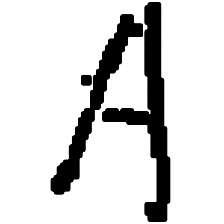

tensor([[-113.2921, -100.8691,  -56.2245,  -71.3873,  -96.4142,  -84.0902,
         -109.6512,  -99.5364,  -43.1381, -100.5666, -111.4466,  -64.8323,
          -90.8725,  -78.7100,  -78.7924,    5.2949,  -98.2765,  -51.9594,
          -36.1661,  -88.6453,   -6.8808,  -20.2104, -104.3090, -102.0830,
          -98.0843,  -47.8391, -100.6188,  -34.6738,    7.6820, -104.8310,
          -63.1145, -117.0858,  -54.8910,  -23.3174,  -72.5454,  -34.4592,
         -107.5692,  -87.9577,  -36.4924, -100.1221,  -46.4797,  -44.2939,
          -79.7053]], device='cuda:0', grad_fn=<MulBackward0>)


IndexError: index 15 is out of bounds for dimension 0 with size 1

In [212]:
import cv2
from PIL import Image, ImageOps

def add_contrast(x, factor):
    return transforms.functional.adjust_contrast(x, factor)

model = mnt.MathNet()
model.load_state_dict(torch.load(MODEL_PATH))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
print('EVALUATION')

img = Image.open("TEST/0.jpg")

#print(img.shape)
convert_tensor = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Grayscale(1),
    # transforms.ToTensor()

])        
x_image = convert_tensor(img)
x_image = add_contrast(x_image, 5)
to_tensor = transforms.ToTensor()

x_image = to_tensor(x_image)
aaa = transforms.ToPILImage()
display(aaa(x_image))
#aaa(x_image).save('a.jpg')

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = model(x_image)
print(pred*10)
printer = PrettyPrinter()
print(pred[0][15])
print(pred.argmax().item())
print(printer.char(pred.argmax().item()))